In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Carregar a base de dados
file_path = 'breast-cancer.csv'
data = pd.read_csv(file_path)

data.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events


In [3]:
# Remover linhas onde qualquer coluna tenha um valor '?'
data_cleaned = data.replace('?', np.nan).dropna()
print("numero de linhas removidas =", len(data) - len(data_cleaned))

data = data_cleaned

numero de linhas removidas = 9


In [4]:
# Gerando um mapeamento para discretizar as variaveis
age_mapping = {'20-29': 0, '30-39': 1, '40-49': 2, '50-59': 3, '60-69': 4, '70-79': 5}
menopause_mapping = {'premeno': 0, 'ge40': 1, 'lt40': 2}
tumor_size_mapping = {'0-4': 0, '5-9': 1, '10-14': 2, '15-19': 3, '20-24': 4, '25-29': 5, '30-34': 6, '35-39': 7, '40-44': 8, '45-49': 9, '50-54': 10}
inv_nodes_mapping = {'0-2': 0, '3-5': 1, '6-8': 2, '9-11': 3, '12-14': 4, '15-17': 5, '24-26': 6}
node_caps_mapping = {'no': 0, 'yes': 1}
breast_mapping = {'left': 0, 'right': 1}
irradiat_mapping = {'no': 0, 'yes': 1}
breast_quad_mapping = {'left_up': 0, 'right_up': 1, 'central': 2, 'left_low': 3, 'right_low': 4}
class_mapping = {'no-recurrence-events': 0, 'recurrence-events': 1}

# Aplicar os mapeamentos
data['age'] = data['age'].map(age_mapping)
data['menopause'] = data['menopause'].map(menopause_mapping)
data['tumor-size'] = data['tumor-size'].map(tumor_size_mapping)
data['inv-nodes'] = data['inv-nodes'].map(inv_nodes_mapping)
data['node-caps'] = data['node-caps'].map(node_caps_mapping)
data['breast'] = data['breast'].map(breast_mapping)
data['irradiat'] = data['irradiat'].map(irradiat_mapping)
data['breast-quad'] = data['breast-quad'].map(breast_quad_mapping)
data['Class'] = data['Class'].map(class_mapping)

# Verificar as primeiras linhas dos dados transformados
data.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,2,0,3,0,1,3,1,0,0,1
1,3,1,3,0,0,1,1,2,0,0
2,3,1,7,0,0,2,0,3,0,1
3,2,0,7,0,1,3,1,3,1,0
4,2,0,6,1,1,2,0,1,0,1


In [5]:
data_unique = data.drop_duplicates()
n_duplicates = len(data) - len(data_unique)
data = data_unique
print("Numero de diplicatas removidas =", n_duplicates)

Numero de diplicatas removidas = 14


In [6]:
# Calcular o escore Z (desvios padrão de distância da média) para cada atributo
z_scores = np.abs(stats.zscore(data))

# Identificar onde há escore Z maior que 3 (outliers)
outliers = (z_scores > 3).sum()

outliers

age             0
menopause       0
tumor-size      0
inv-nodes      10
node-caps       0
deg-malig       0
breast          0
breast-quad     0
irradiat        0
Class           0
dtype: int64

In [7]:
""" # Inicializar o objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar aos dados e transformá-los
data_scaled = scaler.fit_transform(data)

# Converter de volta para DataFrame para manter os rótulos das colunas
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# Verificar as primeiras linhas dos dados normalizados
data_scaled.head() """

' # Inicializar o objeto MinMaxScaler\nscaler = MinMaxScaler()\n\n# Ajustar aos dados e transformá-los\ndata_scaled = scaler.fit_transform(data)\n\n# Converter de volta para DataFrame para manter os rótulos das colunas\ndata_scaled = pd.DataFrame(data_scaled, columns=data.columns)\n\n# Verificar as primeiras linhas dos dados normalizados\ndata_scaled.head() '

In [8]:
class_counts = data['Class'].value_counts()

class_counts

Class
0    186
1     77
Name: count, dtype: int64

In [9]:
data_majority = data[data['Class'] == 0]
data_minority = data[data['Class'] == 1]

# Balanceia as classes retirando 40% da majoritaria e 10% da minoritaria
data_majority_train = resample(data_majority, replace=False, n_samples=int(len(data_majority) * 0.6), random_state=42) 
data_majority_test = data_majority.drop(data_majority_train.index)
data_minority_train = resample(data_minority, replace=False, n_samples=int(len(data_minority) * 0.9), random_state=42) 
data_minority_test = data_minority.drop(data_minority_train.index)

# Combinar os dados
X_train = pd.concat([data_majority_train.drop('Class', axis=1), data_minority_train.drop('Class', axis=1)])
y_train = pd.concat([data_majority_train['Class'], data_minority_train['Class']])
X_test = pd.concat([data_majority_test.drop('Class', axis=1), data_minority_test.drop('Class', axis=1)])
y_test = pd.concat([data_majority_test['Class'], data_minority_test['Class']])

# Inicializar o objeto SMOTE
smote = SMOTE(random_state=42)

# Aplicar o SMOTE para balancear a classe minoritária no conjunto de treino
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train.shape, X_test.shape

((222, 9), (83, 9))

In [10]:
# Definir a rede neural
mlp = MLPClassifier()

# Definir os parâmetros para o GridSearch
parameter_space = {
    'max_iter': [1000],
    'random_state': [42],
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100)],
    'activation': ['relu', 'identity', 'logistic', 'tanh'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Inicializar o GridSearchCV
grid_clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3, verbose=3)
grid_clf.fit(X_train, y_train)

# Ver os melhores parâmetros encontrados
print('Melhores parâmetros encontrados:\n', grid_clf.best_params_)

# Avaliar no conjunto de teste
print('Score no conjunto de teste:', grid_clf.score(X_test, y_test))

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Melhores parâmetros encontrados:
 {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 1000, 'random_state': 42, 'solver': 'adam'}
Score no conjunto de teste: 0.6024096385542169


In [11]:
mlp = MLPClassifier(**grid_clf.best_params_, verbose=True)
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.70690394
Iteration 2, loss = 0.70002364
Iteration 3, loss = 0.69584128
Iteration 4, loss = 0.69362293
Iteration 5, loss = 0.69176952
Iteration 6, loss = 0.68990398
Iteration 7, loss = 0.68807235
Iteration 8, loss = 0.68631634
Iteration 9, loss = 0.68467214
Iteration 10, loss = 0.68331576
Iteration 11, loss = 0.68132855
Iteration 12, loss = 0.67942426
Iteration 13, loss = 0.67797248
Iteration 14, loss = 0.67625251
Iteration 15, loss = 0.67505874
Iteration 16, loss = 0.67398327
Iteration 17, loss = 0.67233614
Iteration 18, loss = 0.67035789
Iteration 19, loss = 0.66832848
Iteration 20, loss = 0.66640552
Iteration 21, loss = 0.66519140
Iteration 22, loss = 0.66384591
Iteration 23, loss = 0.66321274
Iteration 24, loss = 0.66195401
Iteration 25, loss = 0.66030229
Iteration 26, loss = 0.65867407
Iteration 27, loss = 0.65689013
Iteration 28, loss = 0.65551261
Iteration 29, loss = 0.65409102
Iteration 30, loss = 0.65277320
Iteration 31, loss = 0.65150474
Iteration 32, los

MLPClassifier(activation='logistic', hidden_layer_sizes=100, max_iter=1000,
              random_state=42, verbose=True)

Acurácia: 0.60
Recall: 0.75
Precisão: 0.16
Pontuação F1: 0.27


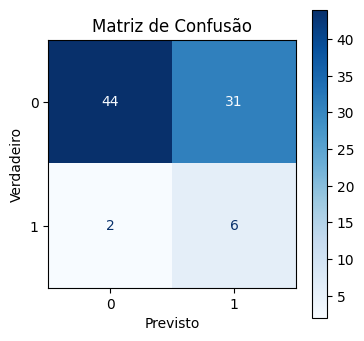

In [12]:
# Fazer previsões no conjunto de teste
y_pred = mlp.predict(X_test)

# Calcular métricas de validação
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir métricas
print(f"Acurácia: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Pontuação F1: {f1:.2f}")

# Gerar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(cmap='Blues', ax=ax)
ax.grid(False)
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()